In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Synthetic data generation

### Define PDF

In [71]:
# Define the triangle probability density function for T
def triangle_pdf(I, Imax):
    if I < 0 or I > Imax:
        return 0
    else:
        return (Imax - I) / (Imax ** 2)

Text(0, 0.5, 'f(I)')

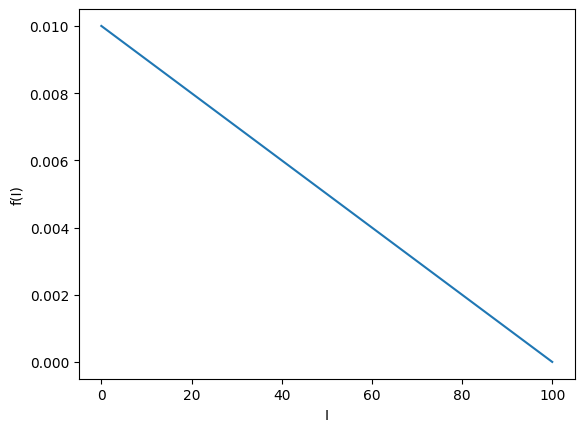

In [72]:
# Sanity check for triangular pdf
x = np.linspace(0,100)
f = lambda z: triangle_pdf(z,100)
v = np.vectorize(f)
y = v(x)
plt.plot(x, y)
plt.xlabel('I')
plt.ylabel('f(I)')

### Custom current function

In [73]:
np.random.seed = 42

In [74]:
# Sample Ij values from the triangle pdf
def sample_Ij(Imax):
    I = np.linspace(0, Imax, 10000)
    return np.random.choice(I, p=[triangle_pdf(x, Imax) for x in I]/sum([triangle_pdf(x, Imax) for x in I]))

In [75]:
# # Define custom current function
def custom_current(I_values, M):
    def current(t):
        I_piecewise = 0
        for j in range(M):
            t1, t2 = j * 100, (j + 1) * 100
            I1, I2 = I_values[j], I_values[j + 1]
            I_current_interval = I1 + (I2 - I1) * (t - t1) / (t2 - t1)
        return I_current_interval
    return current

### Model set up

In [76]:
# Set up the PyBaMM simulation
model = pybamm.lithium_ion.SPM() # should we use SPM or SPMe? 
parameter_values = model.default_parameter_values
Imax = parameter_values["Current function [A]"]

In [77]:
V_min = parameter_values['Lower voltage cut-off [V]']
V_max = parameter_values['Upper voltage cut-off [V]']
print(V_min, V_max)

3.105 4.1


In [78]:
model.events.append(pybamm.Event('Minimum voltage', model.variables['Terminal voltage [V]'] - V_min, pybamm.EventType.TERMINATION))
model.events.append(pybamm.Event('Maximum voltage', V_max - model.variables['Terminal voltage [V]'], pybamm.EventType.TERMINATION))

In [79]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.4,
 'Cell cooling surface area [m2]': 0.0569,
 'Cell volume [m3]': 7.8e-06,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 0.680616,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Capiglia1999 at 0x12912c700>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Capiglia1999 at 0x12912c790>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 19986.609595075,
 'Initial concentration in positive electrode [mol.m-3]': 30730.7554385565,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial outer SEI thickness [m]': 2.5e-09,
 

In [80]:
# How to set initialization as uniform Li-ion concentration in particles and electrolyte?
# initial_soc = 1

# c_n_init = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
# c_p_init = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
# parameter_values["Initial concentration in negative electrode [mol.m-3]"] = c_n_init * initial_soc
# parameter_values["Initial concentration in positive electrode [mol.m-3]"] = c_p_init * initial_soc

In [81]:
Imax

0.680616

In [82]:
M = 15  # Replace with your desired M value
t = [100*i for i in range(M + 1)]
I_values = [sample_Ij(Imax) for i in range(M + 1)]

In [83]:
I_values

[0.560815603960396,
 0.13988057605760576,
 0.04512935373537354,
 0.15478755715571557,
 0.03539557155715571,
 0.16200280828082808,
 0.07718957335733573,
 0.4972397119711971,
 0.0354636399639964,
 0.37920909450945095,
 0.019603701170117012,
 0.19624121692169216,
 0.31127682448244826,
 0.34973547434743474,
 0.3349646300630063,
 0.3926185706570657]

Text(0, 0.5, 'Current (A)')

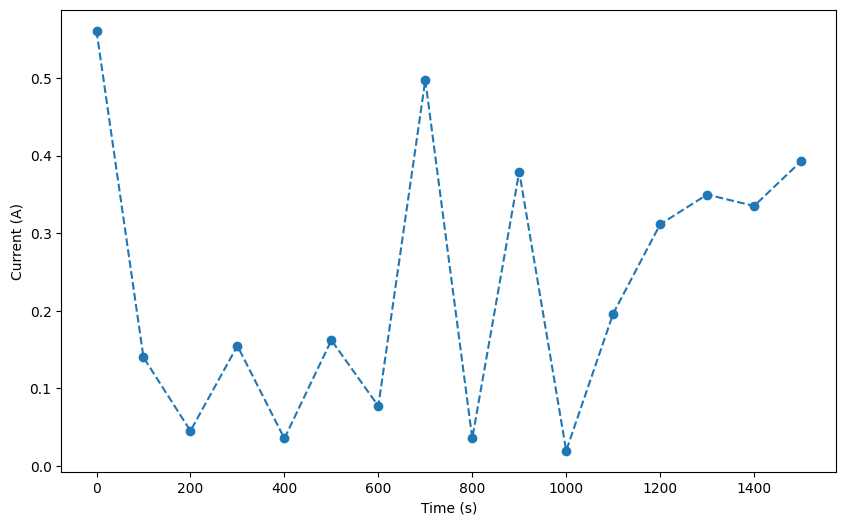

In [84]:
# Plot current function to check
plt.figure(figsize=(10,6))
plt.plot(t, I_values, linestyle='--', marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')

In [85]:
parameter_values["Current function [A]"] = custom_current(I_values, M)

### Run simulation

In [86]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)

In [87]:
sim.model.initial_conditions

{Variable(0x694fc51527645211, Discharge capacity [A.h], children=[], domains={}): Scalar(-0x6cc14c0199e7b7ba, 0.0, children=[], domains={}),
 Variable(0x45659f18bc80555, X-averaged negative particle concentration, children=[], domains={'primary': ['negative particle'], 'secondary': ['current collector']}): XAverage(0x5e6e9370915d5156, x-average, children=['Initial concentration in negative electrode [mol.m-3] / Maximum concentration in negative electrode [mol.m-3]'], domains={'primary': ['negative particle'], 'secondary': ['current collector']}),
 Variable(-0x5cd729ba79ce2cdb, X-averaged positive particle concentration, children=[], domains={'primary': ['positive particle'], 'secondary': ['current collector']}): XAverage(-0x1114ae4ed03a1da9, x-average, children=['Initial concentration in positive electrode [mol.m-3] / Maximum concentration in positive electrode [mol.m-3]'], domains={'primary': ['positive particle'], 'secondary': ['current collector']})}

In [88]:
t_eval = np.linspace(0, 100 * M, 15 + 1)
solution = sim.solve(t_eval=t_eval)

In [89]:
t_eval

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500.])

In [90]:
model.variable_names()

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_n',
 'r_n [m]',
 'r_p',
 'r_p [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Separator porosity',
 'X-averaged separator porosity',
 'Positive electrode porosity',
 'X-averaged positive electrode porosity',
 'Porosity change',
 'Negative electrode porosity change',
 'X-averaged negative electrode porosity change',
 'Separator porosity change',
 'X-averaged separator porosity change',
 'Positive electrode porosity change',
 'X-averaged positive electrode porosity change',
 'Negative electrode interface utilisation variable',
 'X-averaged negative electrode interface utilisation variabl

In [93]:
voltage = solution['Terminal voltage [V]']
neg_conc = solution['Negative particle concentration']
pos_conc = solution['Positive particle concentration']

final_time_idx = -1
neg_conc_final = neg_conc.entries[:, final_time_idx]
pos_conc_final = neg_conc.entries[:, final_time_idx]

#neg_conc_units = solution['Negative particle concentration [mol.m-3]']
#pos_conc_units = solution['Positive particle concentration [mol.m-3]']

In [95]:
solution["Time [s]"].entries

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500.])

### Visualize

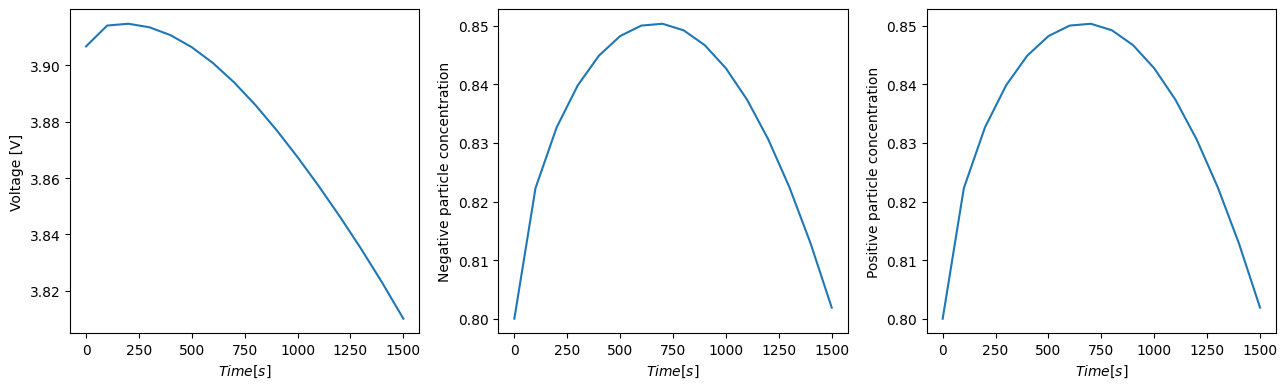

In [100]:
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.plot(t, voltage(t))
ax1.set_xlabel(r'$Time [s]$')
ax1.set_ylabel('Voltage [V]')

ax2.plot(t, neg_conc_final[-1])  # change index to change
ax2.set_xlabel(r'$Time [s]$')
ax2.set_ylabel('Negative particle concentration')

ax3.plot(t, pos_conc_final[-1])  # change index to change x
ax3.set_xlabel(r'$Time [s]$')
ax3.set_ylabel('Positive particle concentration')

plt.tight_layout()
plt.show()

In [101]:
termination_reason = solution.termination

if termination_reason == 'event: Minimum voltage' or termination_reason == 'event: Maximum voltage':
    print("Battery failed during time window __")
else:
    print("Battery did not fail during time window __")

Battery did not fail during time window __


Questions:

- SPM or SPMe?
- What value of Imax to use? Currently set it to value in Current function [A]
- Check on battery failure set-up. Is this the way to do it?
    - How to model the depletion / failure part?
- Do we need to set the initial conditions as outlined in the code?
- Output: surface concentration vs concentration?
- Keras or pytorch?